# Create complete network
- get all layers created so far (IRIS, centroids, roads for cars and bikes, public transport layer(s))

- connect centroids to the carbike network: 
    - combine centroids and carbike nodes into one nodes_network dataframe
    - put the combined nodes and the carbike edges into snkit
    - create a base_network with them, create a linked network
    - go back to separate carbike and centroid dataframes as needed



In [1]:
import networkx as nx
import os
os.environ['USE_PYGEOS'] = '1'
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import shapely
import snkit
import snkit.network
crs_fr = 4326
plt.rcParams['figure.figsize'] = (10, 10)

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Check function
def check_missing_nodes(set11, set12, node_IDs):
    set11 = set(set11)
    set12 = set(set12)
    node_IDs = set(node_IDs)
    IDs_in_edges = set11.union(set12)
    missing = list(sorted(IDs_in_edges - node_IDs))
    added = list(sorted(node_IDs - IDs_in_edges))
    return(missing, added)

In [3]:
# --- From Anastassia
# import packages
%run -i packages.py

# CUSTOM FUNCTION

# define function that creates attribute dictionary for nodes and edges
# (for input to nx.add_edges_from/add_nodes_from)
def make_attr_dict(*args, **kwargs): 
    
    argCount = len(kwargs)
    
    if argCount > 0:
        attributes = {}
        for kwarg in kwargs:
            attributes[kwarg] = kwargs.get(kwarg, None)
        return attributes
    else:
        return None # (if no attributes are given)

## Get layers

In [4]:
# Get boundary of GPM (for plots)
GPM = gpd.read_file('data/raw/GPM_geometry/GPM.geojson').to_crs(crs_fr)

### Centroids

In [5]:
# Get grid and centroids
grid = pd.read_csv('data/processed/IRIS_GPM.csv').drop(columns = 'geometry')

# turn into geodataframe and separate centroids 
grid['centroid'] = grid['centroid'].apply(shapely.wkt.loads)
centroids = grid.rename(columns = {'centroid':'geometry'}).set_geometry('geometry').set_crs(2154)


# Adding necessary attributes for the network
centroids['nodetype'] = 'bike'
centroids['centroid'] = True
centroids['RER'] = False


# Make a new dataframe for the network just in case TODO move to the nextwork building cell 
centroids_network = centroids.to_crs(crs_fr)
centroids_network['x'] = centroids_network['geometry'].x
centroids_network['y'] = centroids_network['geometry'].y


### roads 

In [6]:
# Get roads (car/bike, nodes/edges)
edges_carbike = pd.read_csv("./data/processed/carbike_edges.csv")
nodes_carbike = pd.read_csv("./data/processed/carbike_nodes.csv")

In [7]:
#--- Getting the nodes ready for the network

# Add attributes
nodes_carbike['centroid'] = False
nodes_carbike['RER'] = False    

# Turn into GeoDataFrame
nodes_carbike["geometry"] = nodes_carbike.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
nodes_carbike = gpd.GeoDataFrame(nodes_carbike, geometry = 'geometry', crs = crs_fr)

# Re-create x and y columns
nodes_carbike['x'] = nodes_carbike['geometry'].x
nodes_carbike['y'] = nodes_carbike['geometry'].y


In [8]:
check_missing_nodes(edges_carbike['x'], edges_carbike['y'], nodes_carbike['osmid'])

([], [])

In [9]:
# Turn to GeoDataFrame
edges_carbike["geometry"] = edges_carbike.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_carbike = gpd.GeoDataFrame(edges_carbike, geometry = "geometry", crs = crs_fr) 

In [10]:
check_missing_nodes(edges_carbike['x'], edges_carbike['y'], nodes_carbike['osmid'])

([], [])

#### Find biggest connected component and only work with that

In [11]:
#--- Checking for connectedness 

# Create Networkx Graph
G1 = nx.from_pandas_edgelist(edges_carbike, source='x', target='y', edge_attr=True, create_using=nx.DiGraph)
# G1.add_nodes_from(nodes.loc[:,["osmid", "attr_dict"]].itertuples(index = False))
G1.add_nodes_from(nodes_carbike.loc[:,"osmid"])

# Find disconnected components
S1 = [G1.subgraph(c).copy() for c in nx.weakly_connected_components(G1)] 

#--- Compute some statistics
graph_below_2_nodes = 0
graph_above_2_nodes = 0
big_graph = 0

lengthlist = []
for index in range(len(S1)):
    lengthlist.append(len(S1[index]))
    if len(S1[index]) < 3 :
        graph_below_2_nodes+=1
    elif len(S1[index]) > 100 :
        big_graph +=1
    else:
        graph_above_2_nodes+=1

lengthS1 = 0
for edge in S1[0].edges:
    lengthS1 += edges_carbike.loc[(edges_carbike['x'] == edge[0]) & (edges_carbike['y'] == edge[1]), 'length'].values[0]

# Print the statistics
print("disconnected components with 2 nodes or less ", graph_below_2_nodes)
print("disconnected components with 3 or more nodes, less than 100", graph_above_2_nodes)
print("disconnected components with 100 or more nodes", big_graph)
print("total number of disconnected components", len(S1))
print("Percentage of edges in the largest component", len(S1[0]) / len(edges_carbike) * 100) 
print("Percentage of km of edges in the largest component", lengthS1 / edges_carbike['length'].sum() * 100)

disconnected components with 2 nodes or less  594
disconnected components with 3 or more nodes, less than 100 138
disconnected components with 100 or more nodes 1
total number of disconnected components 733
Percentage of edges in the largest component 55.83971580676443
Percentage of km of edges in the largest component 72.08111674798589


In [12]:
#--- Only work with the largest connected component

# Export the edges of the graph to a pandas dataframe
edges_carbike_connected = nx.to_pandas_edgelist(S1[0], source='x', target='y')
# edges_carbike_connected["geometry"] = edges_carbike_connected.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_carbike_connected = gpd.GeoDataFrame(edges_carbike_connected, geometry = 'geometry', crs = crs_fr)

# Filter the nodes dataframe to only include the nodes that are in the largest connected component
nodes_carbike_connected = nodes_carbike.loc[nodes_carbike['osmid'].isin(edges_carbike_connected['x']) | nodes_carbike['osmid'].isin(edges_carbike_connected['y'])]

In [13]:
# # Plot

# ax = plt.axes()
# edges_carbike_connected.plot(ax=ax, linewidth = 0.3, alpha = 0.5)
# nodes_carbike_connected.plot(ax=ax, markersize = 0.05, facecolor = 'red', alpha = 1)
# GPM.plot(ax=ax, facecolor = 'none', linewidth = 2)

### RER and Metro

In [14]:
#--- Get data
RER_stations = pd.read_csv("./data/processed/RER_stations.csv")
RER_lines = pd.read_csv("./data/processed/RER_lines.csv")

In [15]:
check_missing_nodes(RER_lines.x, RER_lines.y, RER_stations.id) 

([], [])

In [16]:
#--- Add necessary attributes

# For lines
RER_lines['edgetype'] = 'RER'

# For stations
RER_stations['nodetype'] = 'bike'
RER_stations['centroid'] = False
RER_stations['RER'] = True
RER_stations = RER_stations.rename(columns = {'id': 'osmid'})

In [17]:
#--- turn to GeoDataFrame
RER_stations["geometry"] = RER_stations.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
RER_stations = gpd.GeoDataFrame(RER_stations, geometry = 'geometry', crs = 2154).to_crs(crs_fr)
RER_lines["geometry"] = RER_lines.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
RER_lines = gpd.GeoDataFrame(RER_lines, geometry = 'geometry', crs = 2154).to_crs(crs_fr)


## Connect carbike edges and centroids
A network is created with
- nodes = centroids, RER stops and road intersections
- edges = roads

These edges and nodes are connected by creating an edge between each centroid and its nearest edge.

In [18]:
#--- Create dataframe with all carbike nodes and centroids 
nodes_network = pd.concat([RER_stations,centroids_network, nodes_carbike_connected])

<Axes: >

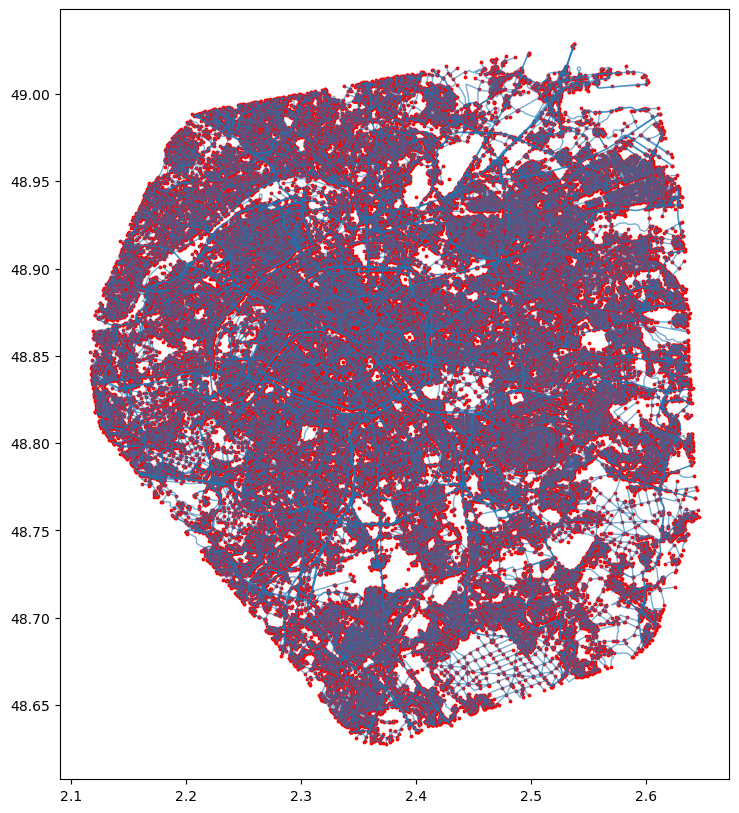

In [19]:
#--- Creating the network 

# Nodes 
nodes = gpd.GeoDataFrame(nodes_network, geometry = "geometry", crs = crs_fr)

# Edges
edges = edges_carbike_connected

# Network
base_network = snkit.Network(nodes, edges)

# Plot
ax = plt.axes()
base_network.edges.plot(ax=ax, linewidth = 1, alpha = 0.6)
base_network.nodes.plot(ax=ax, facecolor = 'red', markersize = 3)

In [20]:
# Quick check of consistency
len(check_missing_nodes(base_network.edges['x'], base_network.edges['y'], base_network.nodes['osmid'])[1]) #2996 is good!

2991

In [21]:
%%time 
#--- Link centroids to their nearest edge (takes about 16min)

linked = snkit.network.link_nodes_to_nearest_edge(base_network) #wth is this warning?
# # plot
# ax = plt.axes()
# linked.edges.plot(ax=ax, linewidth = 1, alpha = 0.5)
# linked.nodes.plot(ax=ax, facecolor = 'red', markersize = 3, alpha = 1)

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


CPU times: user 15min 5s, sys: 6.25 s, total: 15min 11s
Wall time: 15min 19s


In [22]:
# create IDs for the new nodes and edges 
with_id = snkit.network.add_topology(snkit.network.add_ids(linked))

In [23]:
with_id.edges.isnull().sum()
# The edges without and x and y attribute are the ones that were created by the link_nodes_to_nearest_edge function

x           2991
y           2991
length      2991
edgetype    2991
edge_id     2991
geometry       0
id             0
from_id        0
to_id          0
dtype: int64

In [24]:
with_id.nodes.isnull().sum() 
# The nodes that don't have a centroid/nodetype/RER attribute are the newly created nodes (splitting and old edge) = 2851
# The nodes that don't have an osmid are the new nodes + centroids  = 5695

osmid         5695
ligne       118556
x             2851
y             2851
geometry         0
nodetype      2851
centroid      2851
RER           2851
id               0
dtype: int64

In [25]:
# Separate old nodes (centroids and carbike nodes) from new ones (intersection between centroid and nearest edge) 
new_carbike_nodes = with_id.nodes[with_id.nodes['nodetype'].isnull()]

# Separate centroids from the other nodes of this network TODO adapt now that RER has been added
centroids_network = with_id.nodes[with_id.nodes['centroid'] == True]

# Separate RER stations from the other nodes of this network  TODO this is not checked 
RER_stations_network = with_id.nodes[with_id.nodes['RER'] == True]

In [27]:
with_id.nodes.head(10)
# Make sure the first nodes are from the RER network AND their osmid and id overlap!!

,osmid,ligne,x,y,geometry,nodetype,centroid,RER,id
0,0.0,RER C,656121.8463,6.845998e+06,POINT (2.40363 48.71263),bike,False,True,node_0
1,1.0,RER A,650849.5187,6.863779e+06,POINT (2.32993 48.87216),bike,False,True,node_1
2,2.0,RER E,672031.7582,6.856264e+06,POINT (2.61919 48.80584),bike,False,True,node_2
3,3.0,RER C,648906.4362,6.872841e+06,POINT (2.30235 48.95350),bike,False,True,node_3
4,4.0,RER A,664035.4268,6.856435e+06,POINT (2.51031 48.80699),bike,False,True,node_4
5,5.0,RER C,649466.5142,6.849979e+06,POINT (2.31271 48.74794),bike,False,True,node_5
6,6.0,RER E,667206.3725,6.864219e+06,POINT (2.55288 48.87716),bike,False,True,node_6
7,7.0,RER C,654572.5890,6.843468e+06,POINT (2.38285 48.68976),bike,False,True,node_7
8,8.0,RER A,664256.3285,6.855144e+06,POINT (2.51342 48.79538),bike,False,True,node_8
9,9.0,RER B,657928.4900,6.870237e+06,POINT (2.42579 48.93074),bike,False,True,node_9


## Post-linking processing

### Nodes
- Make centroids compatible with carbike nodes
- Make the new nodes compatible with the carbike nodes
- Add the new nodes to the carbike nodes
- Process all carbike nodes (old and new)

In [28]:
#--- Process centroids 
centroids_network = centroids_network.drop(columns = 'osmid')
centroids_network = centroids_network.rename(columns = {'id':'osmid'})
centroids_network['osmid'] = centroids_network['osmid'].str[5:].astype(int)

centroids_network.head(3)

,ligne,x,y,geometry,nodetype,centroid,RER,osmid
147,NaN,2.374640,48.869834,POINT (2.37464 48.86983),bike,True,False,147
148,NaN,2.289280,48.895206,POINT (2.28928 48.89521),bike,True,False,148
149,NaN,2.402726,48.922227,POINT (2.40273 48.92223),bike,True,False,149


In [29]:
#--- Process new carbike nodes 
new_carbike_nodes = new_carbike_nodes.drop(columns = 'osmid')
new_carbike_nodes = new_carbike_nodes.rename(columns = {'id':'osmid'})

# Add attributes 
new_carbike_nodes['nodetype'] = 'bike'
new_carbike_nodes['osmid'] = new_carbike_nodes['osmid'].str[5:].astype(int)
new_carbike_nodes['centroid'] = False
new_carbike_nodes['RER'] = False

new_carbike_nodes.tail(1)

,ligne,x,y,geometry,nodetype,centroid,RER,osmid
118702,NaN,NaN,NaN,POINT (2.27667 48.76703),bike,False,False,118702


In [30]:
#--- Process RER nodes
RER_stations_network['osmid'] = RER_stations_network['osmid'].astype(int)
RER_stations_network = RER_stations_network.drop(columns = 'id')
RER_stations_network.head(1)

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,osmid,ligne,x,y,geometry,nodetype,centroid,RER
0,0,RER C,656121.8463,6.845998e+06,POINT (2.40363 48.71263),bike,False,True


In [31]:
#-- Process old carbike nodes
nodes_carbike_connected.head(1)

,osmid,y,x,geometry,nodetype,centroid,RER
0,122926,48.884082,2.463549,POINT (2.46355 48.88408),car,False,False


In [32]:
# QUICK CHECK: ARE ALL IDs REALLY DIFFERENT FROM EACH OTHER? 
RER_stations_network_minID = int(RER_stations_network.sort_values(by = 'osmid').head(1).osmid)
RER_stations_network_maxID = int(RER_stations_network.sort_values(by = 'osmid').tail(1).osmid)
centroids_minID = int(centroids_network.sort_values(by = 'osmid').head(1).osmid)
centroids_maxID = int(centroids_network.sort_values(by = 'osmid').tail(1).osmid)
new_carbike_nodes_minID = int(new_carbike_nodes.sort_values(by = 'osmid').head(1).osmid)
new_carbike_nodes_maxID = int(new_carbike_nodes.sort_values(by = 'osmid').tail(1).osmid)
nodes_all_minID = int(nodes_carbike_connected.sort_values(by = 'osmid').head(1).osmid)
nodes_all_maxID = int(nodes_carbike_connected.sort_values(by = 'osmid').tail(1).osmid)

print('\nRER min ', RER_stations_network_minID, 
      '\nRER min ', RER_stations_network_maxID, 
      '\ncentroid min ', centroids_minID, 
      '\ncentroid max ', centroids_maxID, 
      '\nnew carbike min ', new_carbike_nodes_minID, 
      '\nnew carbike max ', new_carbike_nodes_maxID,
      '\nold carbike min ', nodes_all_minID, 
      '\nold carbike max ',nodes_all_maxID) 


RER min  0 
RER min  146 
centroid min  147 
centroid max  2990 
new carbike min  115852 
new carbike max  118702 
old carbike min  122926 
old carbike max  10841468857


In [33]:
#--- Combine all nodes 
nodes_carbike_centroids_RER_complete = pd.concat([nodes_carbike_connected, new_carbike_nodes, centroids_network, RER_stations_network]) 
nodes_carbike_centroids_RER_complete = gpd.GeoDataFrame(nodes_carbike_centroids_RER_complete, geometry = "geometry", crs=crs_fr)

# Replace or fill in x and y attributes
nodes_carbike_centroids_RER_complete = nodes_carbike_centroids_RER_complete.to_crs(2154)
nodes_carbike_centroids_RER_complete['x'] = nodes_carbike_centroids_RER_complete.geometry.apply(lambda p: p.x)
nodes_carbike_centroids_RER_complete['y'] = nodes_carbike_centroids_RER_complete.geometry.apply(lambda p: p.y)

#--- Dealing with the nodes like we used to (Anastassia) 
# Sort values and drop duplicates 
nodes_carbike_centroids_RER_complete = nodes_carbike_centroids_RER_complete.sort_values(by = "osmid").reset_index(drop = True) # sort by osmid
# make attribute dictionary with type and geocoordinates for each node
# MOD: removed category_node = x.type 
# MOD: changed coord to geometry
# MOD-Stpehan : split geometry into lat and lon
# MOD: added centroid and RER as attributes 
nodes_carbike_centroids_RER_complete["attr_dict"] = nodes_carbike_centroids_RER_complete.apply(lambda x: make_attr_dict(lat = x.x,
                                                                  lon = x.y,
                                                                  pos = (x.x, x.y),
                                                                  nodetype = x.nodetype,
                                                                  centroid = x.centroid,
                                                                  RER = x.RER),
                                                                  axis = 1) 

nodes_carbike_centroids_RER_complete["osmid"] = nodes_carbike_centroids_RER_complete["osmid"].astype(int)
nodes_carbike_centroids_RER_complete.head(1) #make sure the top nodes are RER!

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_18432/3278101907.py:2: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  nodes_carbike_centroids_RER_complete = pd.concat([nodes_carbike_connected, new_carbike_nodes, centroids_network, RER_stations_network])


,osmid,y,x,geometry,nodetype,centroid,RER,ligne,attr_dict
0,0,6.845998e+06,656121.846299,POINT (656121.846 6845998.147),bike,False,True,RER C,"{'lat': 656121.8462992132, 'lon': 6845998.1465..."


In [34]:
# QUICK CHECKS 
# This should be 118704, or the max id of the centroids/new carbike nodes/RER nodes together 
print('max id of nodes that are NOT in the edges dataframe ',
      max(check_missing_nodes(linked.edges['x'], linked.edges['y'], nodes_carbike_centroids_RER_complete['osmid'])[1])) 
# This should be 5840, same reasoning as above
print('number of nodes that are NOT in the edges dataframe ',
      len(check_missing_nodes(linked.edges['x'], linked.edges['y'], nodes_carbike_centroids_RER_complete['osmid'])[1])) 

# This should be nan
print('number of edges with nodes that are NOT in the nodes dataframe ', 
      min(check_missing_nodes(linked.edges['x'], linked.edges['y'], nodes_carbike_centroids_RER_complete['osmid'])[0])) 



max id of nodes that are NOT in the edges dataframe  118702
number of nodes that are NOT in the edges dataframe  5842
number of edges with nodes that are NOT in the nodes dataframe  nan


### Edges
- Make new edges compatible with the old ones
    - some new edges connect with a node from the carbike network using the ID given by linked_network instead of the original osmID -> change these IDs into their osmIDs AND update this info in the edges df
    - These IDs are already absent from the nodes_carbike_complete df since it is based on the old nodes_all df and the new_nodes and centroids dfs

In [35]:
#--- Make with_id.nodes and edges workable

n = 5
edges_with_id = with_id.edges
edges_with_id['from_id'] = edges_with_id['from_id'].str[5:].astype(int)
edges_with_id['to_id'] = edges_with_id['to_id'].str[5:].astype(int)
edges_with_id['id'] = edges_with_id['id'].str[5:].astype(int)

print(max(check_missing_nodes(edges_with_id['from_id'], edges_with_id['to_id'], nodes_carbike_connected['osmid'])[0]) )
# highest missing id in edges should be BELOW all of those in the nodes dataframe (i.e below 122926) 

print(min(check_missing_nodes(edges_with_id['from_id'], edges_with_id['to_id'], nodes_carbike_connected['osmid'])[1]) )
# lowest missing ID in nodes should be the lowest original osmid (i.e 122926), need to overwrite the nodes id in edges with their new value

118702
122926


In [36]:
#--- Replacing new IDs with osmIDs where necessary

# Create a dictionary of ID to osmID
oldnodes_in_newedges = with_id.nodes.loc[(with_id.nodes['osmid'].notnull())] # They have an non-null osmID (the new nodes don't have one)
oldnodes_in_newedges['osmid'] = oldnodes_in_newedges['osmid'].astype(int)
oldnodes_in_newedges['id'] = oldnodes_in_newedges['id'].str[5:].astype(int)
oldnodes_in_newedges.set_index('id',inplace=True)
id_osmid_dict = oldnodes_in_newedges.to_dict()['osmid']

# Replace IDs with osmIDs in the edges dataframe
edges_with_id['from_id'] = edges_with_id['from_id'].apply(lambda row: id_osmid_dict[row] if row in (id_osmid_dict.keys()) else row)
edges_with_id['to_id'] = edges_with_id['to_id'].apply(lambda row: id_osmid_dict[row] if row in (id_osmid_dict.keys()) else row)

edges_with_id.isnull().sum()

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


x           2991
y           2991
length      2991
edgetype    2991
edge_id     2991
geometry       0
id             0
from_id        0
to_id          0
dtype: int64

In [37]:
#--- Fill in the edgetype for the new edges 
# Create a dictionary of nodeID to nodetype
nodes_type_df = nodes_carbike_centroids_RER_complete
nodes_type_dict = nodes_type_df.reset_index(drop = True)
nodes_type_dict = nodes_type_dict.set_index('osmid').to_dict()['nodetype']


# Find the correct column indexes to work with
index_edgetype = edges_with_id.columns.get_loc("edgetype")
index_fromID = edges_with_id.columns.get_loc("from_id")
index_toID = edges_with_id.columns.get_loc("to_id")
index_x = edges_with_id.columns.get_loc("x")
index_y = edges_with_id.columns.get_loc("y")
index_edge_id = edges_with_id.columns.get_loc("edge_id")

# Fill in the edgetype 
# With the nodetype of the from_id and to_id if it is the same
# With 'car' if it is different
for i in range(len(edges_with_id)):
    if pd.isnull(edges_with_id.iloc[i,index_edgetype]):
        if nodes_type_dict[edges_with_id.iloc[i,index_fromID]] == nodes_type_dict[edges_with_id.iloc[i,index_toID]]:
            edges_with_id.iloc[i,index_edgetype] = nodes_type_dict[edges_with_id.iloc[i,index_toID]]
        else:
            edges_with_id.iloc[i,index_edgetype] = 'car'
edges_with_id.isnull().sum() # no more NaN on edgetype?

x           2991
y           2991
length      2991
edgetype       0
edge_id     2991
geometry       0
id             0
from_id        0
to_id          0
dtype: int64

In [42]:
#--- Fill in the x and y columns where they are NaN
# With x = from_id and y = to_id
for i in range(len(edges_with_id)):
      if pd.isnull(edges_with_id.iloc[i,index_x]):
         edges_with_id.iloc[i,index_x] = edges_with_id.iloc[i,index_fromID]
         edges_with_id.iloc[i,index_y] = edges_with_id.iloc[i,index_toID]
edges_with_id['x'] = edges_with_id['x'].astype(int)
edges_with_id['y'] = edges_with_id['y'].astype(int)


#--- Fill in the edge_id column where it is NaN with [from_id, to_id]
edges_with_id['edge_id'] = edges_with_id.apply(lambda row: str([row["x"], row["y"]]), axis = 1)
# Convert edges_with_id.edge_id from string to list of int
edges_with_id['edge_id'] = edges_with_id['edge_id'].apply(lambda cell:
                                      ''.join(c for c in cell if c not in "'[]").split(', '))

#--- Drop unnecessary columns
edges_with_id = edges_with_id.drop(['from_id','to_id', 'id'], axis = 1)

edges_with_id.isnull().sum() # no more NaN on x, y and edge_id?

x              0
y              0
length      2991
edgetype       0
edge_id        0
geometry       0
dtype: int64

In [51]:
#--- Adding the RER line

# Append RER edges 
# edges_with_id = edges_with_id.append(RER_lines.drop(columns = 'reseau'), ignore_index = True)

# Are all RER stations connected to RER lines?
# Are all RER lines starting at ending at RER nodes?
print(check_missing_nodes(edges_with_id.loc[edges_with_id['edgetype'] == 'RER']['x'], 
                    edges_with_id.loc[edges_with_id['edgetype'] == 'RER']['y'], 
                    nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['RER']==True]['osmid'])
)

# Are all RER lines present?
print('forgotten lines = ', len(RER_lines) - len(edges_with_id.loc[edges_with_id['edgetype'] == 'RER']))
# Are all RER stations present?
print('forgotten stations = ', len(RER_stations) - len(nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['RER']==True]))


([], [])
forgotten lines =  0
forgotten stations =  0


In [55]:
#--- Fill in the 'length' column
edges_with_id = edges_with_id.set_crs(crs_fr).to_crs(2154) #change crs for accuracy of length
edges_with_id['length'] = edges_with_id.length
edges_with_id = edges_with_id.to_crs(crs_fr) #change crs back to original 

#--- Drop duplicates
edges_with_id = edges_with_id.drop_duplicates(subset = ["x", "y"], keep = "first", ignore_index = True)

edges_with_id.isnull().sum() # no more NaNs at all!!

x           0
y           0
length      0
edgetype    0
edge_id     0
geometry    0
dtype: int64

In [56]:
# Add travel time column
# TODO check RER speed
# TODO double-check whether the whole RER stuff worked out

# Define speeds in meters per minute #TODO add source
speed_dict = {'bike' : 250,
              'both' : 250, # If you can bike then you will bike
              'car' : 83.3,
              'RER' : 1000}

edges_with_id['weight'] = edges_with_id.apply(lambda row: row['length'] / speed_dict[row['edgetype']], axis = 1)
edges_with_id.head(1)

,x,y,length,edgetype,edge_id,geometry,weight
0,122926,318399738,1622.179102,car,"[122926, 318399738]","LINESTRING (2.46355 48.88408, 2.46236 48.88415...",19.473939


In [57]:
print(check_missing_nodes(edges_with_id['x'], edges_with_id['y'], nodes_carbike_centroids_RER_complete['osmid']))
# First list empty:all nodes in nodes_carbike_complete are present in some edge of edges_with_id
# Second list empty:  all nodes in edges_with_id exist in nodes_carbike_complete

([], [])


## Creating the NetworkX Graph

In [58]:
nodes_carbike_centroids_RER_complete.head(1)

,osmid,y,x,geometry,nodetype,centroid,RER,ligne,attr_dict
0,0,6.845998e+06,656121.846299,POINT (656121.846 6845998.147),bike,False,True,RER C,"{'lat': 656121.8462992132, 'lon': 6845998.1465..."


In [59]:
edges_with_id.head(1)

,x,y,length,edgetype,edge_id,geometry,weight
0,122926,318399738,1622.179102,car,"[122926, 318399738]","LINESTRING (2.46355 48.88408, 2.46236 48.88415...",19.473939


In [98]:
#--- Create Graph with all nodes and edges
G = nx.from_pandas_edgelist(edges_with_id, source='x', target='y', edge_attr=True)
G.add_nodes_from(nodes_carbike_centroids_RER_complete.loc[:,["osmid", "attr_dict"]].itertuples(index = False))

#--- Check if all nodes and edges are present
# Both should be 0
print(len(G.nodes()) - len(nodes_carbike_centroids_RER_complete))
print(len(G.edges()) - len(edges_with_id)) 


0
0


In [99]:
#--- Create "bikeable" network B (Anastassia)
B = G.copy()
bikeable_nodes = [node for node in B.nodes if B.nodes[node]["nodetype"]!="car"]
B_noncar_induced = B.subgraph(bikeable_nodes).copy() 

# induced subgraph - still contains the car edges that lie between multi nodes; - exclude them:
banw = B_noncar_induced.copy()
banw.remove_edges_from([edge for edge in banw.edges if banw.edges[edge]["edgetype"]=="car"])
banw.remove_edges_from([edge for edge in banw.edges if banw.edges[edge]["edgetype"]=="RER"])

#--- Check if all nodes and edges are present
# Both should be 0
print(len(banw.nodes()) 
      - len(nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['nodetype'] == 'bike']))
print(len(banw.edges()) 
      - len(edges_with_id.loc[edges_with_id['edgetype'] == 'bike']) 
      - len(edges_with_id.loc[edges_with_id['edgetype'] == 'both'])) 


0
0


In [93]:
#--- Make both networks undirected
G = G.to_undirected()
banw = banw.to_undirected()

In [100]:
#--- Routing between centroids
# TODO something's wrong, but that's not for today. 
# Pick two random nodes with centroid = True
start_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['centroid'] == True].sample(1)
end_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['centroid'] == True].sample(1)

# Check if they are connected on the bike network
print(nx.has_path(banw, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0]))

# Check if they are connected on the car network
print(nx.has_path(G, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0]))


False
False


In [101]:
#--- Routing between RER stations

# Pick two random nodes with RER = True
start_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['RER'] == True].sample(1)
end_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['RER'] == True].sample(1)

# Check if they are connected on the bike network
print(nx.has_path(banw, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0]))

# Check if they are connected on the car network
print(nx.has_path(G, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0]))



False
True


## What's next?

BUILDING THE SKELETAL NETWORK --April--
- ~~finish cleaning up edges/nodes for carbike after linking them with the centroids~~
    - ~~edges need~~
        - ~~to have info on the travel mode (car/bike/public transport)~~
        - ~~weight = travel time for the relevant transport mode~~
        - ~~origin and destination node IDs~~
- ~~Figure out how to export the whole thing to NetworkX~~
- ~~create separate subnetworks for car and bike travel~~
- add restriction on how to travel 
- send visuals and stuff to Anastassia and Trivik
GOAL: I can pick two centroids and find the shortest path, which is all walk, all bike, or walk/bike to station then walk 




SOCIAL STUFF -- second midterm (May 22nd)--
- define needed data for POIs and people 
- find data for POIs and people
- add all of it to centroids
- find/define OD matrix
GOAL: I can pick one pop and one POI and find the shortest path




OPTIMISATION STUFF (June)
- find algorithm
- modify network to allow for optimisation
- do whatever it takes to get stuff to run
- first results!! 
